<a href="https://colab.research.google.com/github/Ramyrahmeni/gpt2-from-scratch/blob/main/gpt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tiktoken datasets pandas



Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Example for CUDA 11.8
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install huggingface_hub

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install  ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install  matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install  tensorflow


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset


import math
import pandas as pd
import tiktoken


In [ ]:
import matplotlib

# Part 1 : GPT 2 Architecture

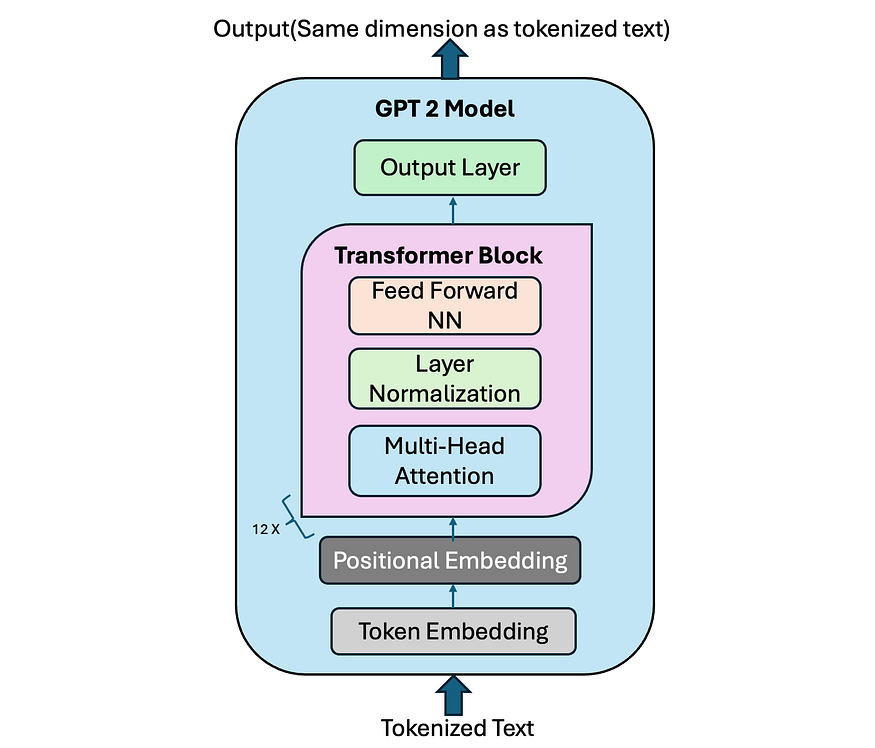

### Tokenization

For tokenization, I applied Byte Pair Encoding (BPE) to break text into subword units, effectively addressing the out‑of‑vocabulary problem found in traditional word‑level encoders, and used the tiktoken library to map text into the GPT‑2 token IDs.

In [ ]:

enc = tiktoken.get_encoding("gpt2")

In [ ]:
#Size of vocabloary
enc.n_vocab

50257

In [ ]:
# Example
tokens=enc.encode("this is a test")
tokens.append(enc.eot_token) # End of text token
print(tokens)
decoded_text=enc.decode(tokens)
print(decoded_text)

[5661, 318, 257, 1332, 50256]
this is a test<|endoftext|>


In [ ]:
def encode_text(text):
  """Encodes text using the GPT-2 encoding and appends the end-of-text token."""
  tokens = enc.encode(text)
  tokens.append(enc.eot_token)
  return tokens

def decode_tokens(tokens):
  """Decodes a list of tokens using the GPT-2 encoding."""
  return enc.decode(tokens)

These functions serve as the foundational text encoding and decoding utilities within the GPT architecture. They facilitate the conversion of human-readable text into numerical token representations for processing by the model, and vice versa, enabling the model to generate coherent and meaningful text outputs.

## Token Embedding

Token embeddings convert discrete input tokens (words or subwords) into continuous numerical vectors, enabling the model to process and represent language. They serve as the foundation for capturing the semantic meaning of tokens and form the first step in how the model understands text.

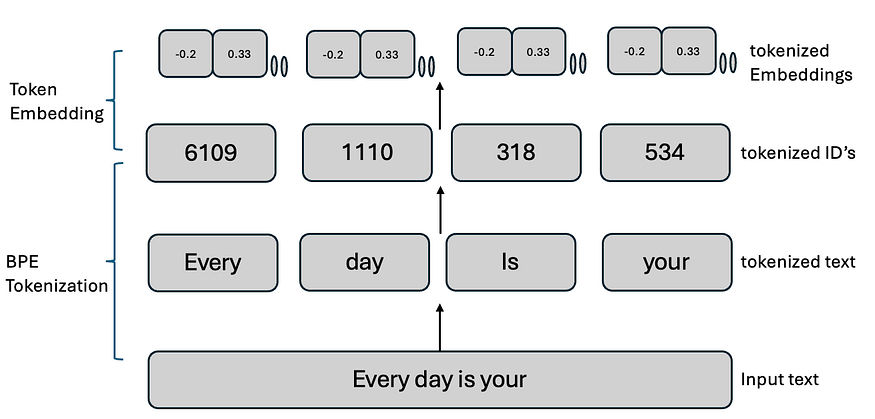

In [ ]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()  # initialize nn.Module
        self.embedding = nn.Embedding(vocab_size, embedding_size)

    def forward(self, x):

        return self.embedding(x)

In [ ]:
# Example

tokens_tensor = torch.tensor(tokens).unsqueeze(0)

print(tokens_tensor)
print(tokens_tensor.shape)
embedding = EmbeddingLayer(vocab_size=50257, embedding_size=768)

# Get embeddings
emb = embedding(tokens_tensor)

print(emb)  # (1, 3, 768)
print(emb.shape)

tensor([[ 5661,   318,   257,  1332, 50256]])
torch.Size([1, 5])
tensor([[[ 0.5438,  1.0335,  0.3444,  ...,  0.8690, -0.0450, -0.3707],
         [ 0.3170,  0.4535, -0.3945,  ...,  1.1892,  1.9888,  0.0176],
         [-0.4145,  0.7562,  0.9617,  ...,  0.5720,  1.3171, -0.6009],
         [-1.3095,  1.4812, -0.3612,  ...,  0.3200, -2.4145, -0.3844],
         [ 0.4270, -1.1371, -1.4918,  ...,  0.6557, -0.0594,  0.9376]]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([1, 5, 768])


## Postional Embedding

Token embeddings capture *what* a word (or subword) means, but they do not encode *where* it appears in a sequence.  
To solve this, we introduce **positional embeddings**, which assign each position in the input a unique continuous vector.

### Key Requirements
- **Consistent Identifiers**  
  Each position must always map to the **same unique identifier**, so the model can recognize order consistently.

- **Preserve Semantic Meaning**  
  Positiona[link text](https://)l signals should not overpower token embeddings.  
  If positional values are too large, they may **wipe out semantic similarity** between tokens.  
  To avoid this, we use functions like **sine and cosine** that produce values in a bounded range `[-1, 1]`.

### Core Idea
The goal is to transform every position index into a **continuous vector signal** that:
- Reflects the relative and absolute position of words  
- Integrates smoothly with token embeddings  
- Allows the model to capture sequence order **without erasing the semantic meaning** of the tokens

### Formula (Sinusoidal Encoding)
For a given position `pos` and embedding dimension `i`:

$$
PE_{(pos, 2i)}   = \sin\left(\frac{pos}{10000^{2i/d}}\right), \quad
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d}}\right)
$$
Here, `d` is the embedding size.  
This ensures:
- Every position has a **unique pattern** of sine and cosine values  
- Nearby positions produce **similar signals**, preserving order information


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        positions = torch.arange(max_len).unsqueeze(1)

        # frequencies: (1, embedding_size/2)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )

        # compute pe: (max_len, embedding_size)
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(positions * div_term)  # even indices
        pe[:, 1::2] = torch.cos(positions * div_term)  # odd indices

        pe = pe.unsqueeze(0)  # (1, max_len, embedding_size)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


In [ ]:
postional_embedding = PositionalEncoding(d_model=768,max_len=5)
pos_emb=postional_embedding(emb)
print(pos_emb)
print(pos_emb.shape)
input_embeddings = pos_emb + emb
print(input_embeddings)
print(input_embeddings.shape)



tensor([[[ 0.5438,  2.0335,  0.3444,  ...,  1.8690, -0.0450,  0.6293],
         [ 1.1584,  0.9938,  0.4339,  ...,  2.1892,  1.9889,  1.0176],
         [ 0.4948,  0.3401,  1.8897,  ...,  1.5720,  1.3173,  0.3991],
         [-1.1683,  0.4913, -0.1501,  ...,  1.3200, -2.4142,  0.6156],
         [-0.3298, -1.7908, -2.1834,  ...,  1.6557, -0.0590,  1.9376]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 5, 768])
tensor([[[ 1.0877,  3.0670,  0.6888,  ...,  2.7380, -0.0900,  0.2585],
         [ 1.4754,  1.4474,  0.0394,  ...,  3.3784,  3.9776,  1.0351],
         [ 0.0803,  1.0963,  2.8513,  ...,  2.1439,  2.6344, -0.2019],
         [-2.4778,  1.9725, -0.5112,  ...,  1.6399, -4.8287,  0.2312],
         [ 0.0972, -2.9279, -3.6752,  ...,  2.3115, -0.1185,  2.8752]]],
       grad_fn=<AddBackward0>)
torch.Size([1, 5, 768])


## Transformer Block

The **Transformer Block** is the fundamental building unit of GPT‑2.  
I designed it by dividing each core component into its own class and then tying them together in a single block for clarity and modularity.

### Structure

1. **LayerNorm → Masked Multi-Head Attention (MMHA)**
   - Normalizes inputs for stability.
   - Applies masked multi-head attention to capture relationships between tokens while preventing access to future positions.
   - Output is added back to the input through a residual connection with dropout.

2. **LayerNorm → Feed-Forward Network (FFN)**
   - Normalizes the updated representation.
   - Passes each token independently through a feed-forward network with a GELU activation.
   - Expands the dimensionality (`4 × embed_dim`) and projects back down.
   - Residual connection and dropout are applied again.

### Why this design?
- **Modularity:** Each component (MMHA, FFN, LayerNorm, Dropout) is implemented as a separate class, making the code clean and reusable.
- **Pre-Norm Architecture:** Normalization happens before MMHA and FFN for more stable training in deep networks.
- **Residual Connections:** Ensure stable gradient flow and prevent vanishing gradients.

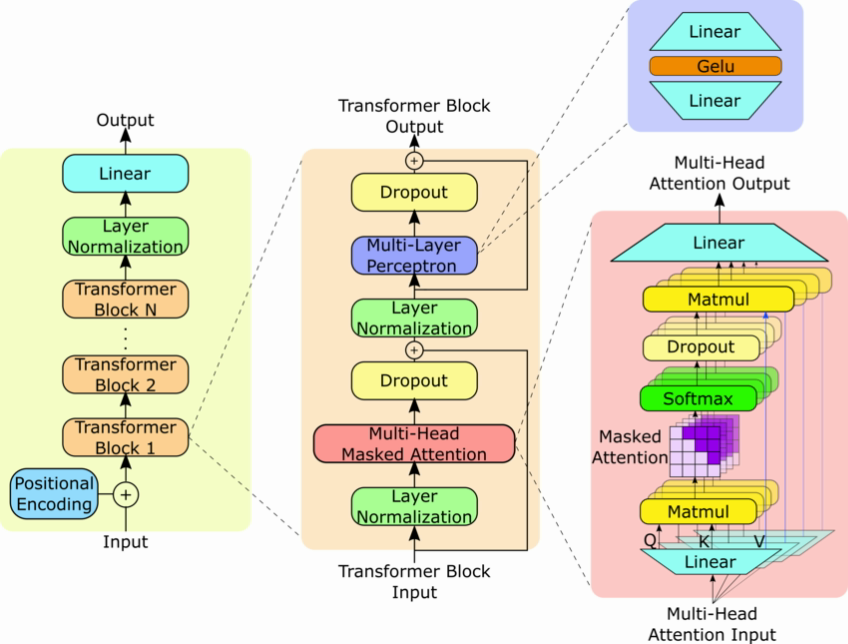

**Masked multi Head Attention**

Masked multi-head attention is the fundamental mechanism in transformer blocks that captures intricate relationships between tokens, such as syntactic structure, semantic similarity, and long-range dependencies.

It operates on three learned projections — **queries (Q)**, **keys (K)**, and **values (V)** — each split across multiple heads to attend to diverse aspects of the input.

The process is as follows:  
1. **Compute attention scores** by multiplying queries with the transposed keys, quantifying the relevance of each token to every other.  
2. **Scale the scores** by the square root of the head dimension to maintain numerical stability and ensure well-behaved gradients.  
3. **Apply a causal mask** to prevent information leakage from future tokens, preserving the autoregressive property.  
4. **Normalize with softmax** to convert raw scores into interpretable probabilities that sum to one.  
5. **Weight the values** by these probabilities to produce context-aware token representations that integrate relevant information across the sequence.

This elegant mechanism enables the model to dynamically focus on multiple relational aspects simultaneously, enriching its contextual understanding.


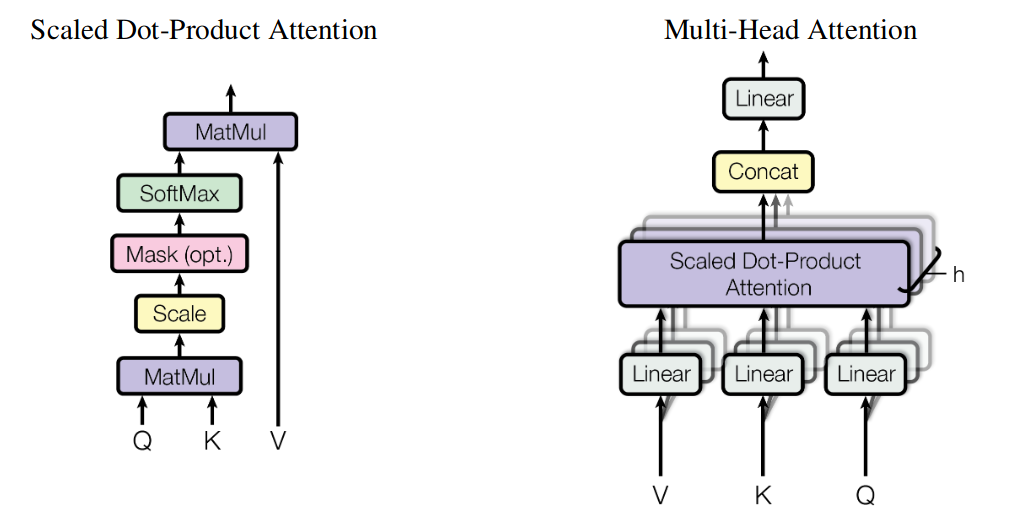

Remark:
We scale the attention scores by dividing by the square root of the head dimension primarily to mitigate covariate shift and stabilize gradients during training. Without this scaling, the dot products can grow large in magnitude as the dimension increases, causing the softmax function to produce extremely small gradients and making training unstable. Dividing by √(head_dim) keeps the values in a manageable range, ensuring more effective learning.

In [ ]:
class MMHAttention(nn.Module):
    def __init__(self, d_in, d_out, embed_dim, num_heads, seq_len):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(d_in, d_out)
        self.k_proj = nn.Linear(d_in, d_out)
        self.v_proj = nn.Linear(d_in, d_out)

        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(0.1)

        self.register_buffer(
            "mask",
            torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0)
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        queries = self.q_proj(x)
        keys    = self.k_proj(x)
        values  = self.v_proj(x)

        queries = queries.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        keys    = keys.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        values  = values.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(self.head_dim)
        mask = self.mask[:, :, :seq_len, :seq_len].to(x.device)
        scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, values)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)

        attn_output = self.dropout(self.out_proj(attn_output))
        return attn_output

In [ ]:
#Example Hyperparameters for test
batch_size = 2
seq_len = 10
d_in = 64       # input feature dimension
d_out = 64      # output feature dimension (usually same as embed_dim)
embed_dim = 64
num_heads = 8

# Attention layer
print(d_in, d_out, embed_dim, num_heads, seq_len)
attn = MMHAttention(d_in, d_out, embed_dim, num_heads, seq_len)
# Dummy input tensor (batch_size, seq_len, d_in)
x = torch.randn(batch_size, seq_len, d_in)

# Forward pass
output = attn(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

64 64 64 8 10
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])


**Layer Normalization**


We use Layer Normalization to stabilize and speed up training by normalizing each token’s feature vector, which helps prevent issues like internal covariate shift.

The normalization is computed as follows:

$$
\mu = \text{mean}(x), \quad \sigma^2 = \text{var}(x)
$$

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} \quad,\quad y_i = \gamma \hat{x}_i + \beta
$$

where the mean and variance are computed across the feature dimension for each input vector:

$$
\mu = \text{mean}(x), \quad \sigma^2 = \text{var}(x)
$$
Epsilon is a small constant added for numerical stability to avoid division by 0.


The scale and shift parameters are learnable:

$$
\gamma, \quad \beta
$$
- **Objective:** Normalize each feature vector to have zero mean and unit variance, then apply learnable scaling (`γ`) and shifting (`β`).

- **Input:** A tensor of shape `(batch_size, seq_len, embedding_dim)`, e.g., `(2, 3, 4)`.

- **Process:**
  1. Compute mean and variance across the last dimension (features) for each vector.
  2. Normalize features by subtracting the mean and dividing by the standard deviation.
  3. Scale and shift normalized values using learnable parameters `γ` (gamma) and `β` (beta).

- **Expected Output:** Each feature vector is normalized. Initially, since `γ = 1` and `β = 0`, output vectors have zero mean and unit variance.

This test verifies that the LayerNorm implementation correctly normalizes input data on the feature dimension.


In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))  # scale parameter
        self.beta = nn.Parameter(torch.zeros(dim))  # shift parameter

    def forward(self, x):
        # Compute mean and variance along the last dimension (features)
        mean = torch.mean(x, dim=-1, keepdim=True)
        var = torch.var(x, dim=-1, keepdim=True, unbiased=False)

        # Normalize input
        x_norm = (x - mean) / torch.sqrt(var + self.eps)

        # Scale and shift
        return self.gamma * x_norm + self.beta


In [ ]:
layer_norm = LayerNorm(dim=4)

# Sample input tensor (batch_size=2, seq_len=3, embedding_dim=4)
x = torch.tensor([
    [[2.0, 4.0, 6.0, 8.0],
     [1.0, 3.0, 5.0, 7.0],
     [0.0, 2.0, 4.0, 6.0]],
    [[8.0, 6.0, 4.0, 2.0],
     [7.0, 5.0, 3.0, 1.0],
     [6.0, 4.0, 2.0, 0.0]]
])

# Forward pass
output = layer_norm(x)
print("Input:\n", x)
print("Output:\n", output)

Input:
 tensor([[[2., 4., 6., 8.],
         [1., 3., 5., 7.],
         [0., 2., 4., 6.]],

        [[8., 6., 4., 2.],
         [7., 5., 3., 1.],
         [6., 4., 2., 0.]]])
Output:
 tensor([[[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]],

        [[ 1.3416,  0.4472, -0.4472, -1.3416],
         [ 1.3416,  0.4472, -0.4472, -1.3416],
         [ 1.3416,  0.4472, -0.4472, -1.3416]]], grad_fn=<AddBackward0>)


**Dropout Layer**

Dropout is a regularization technique used during training to prevent overfitting. It works by randomly “dropping” (setting to zero) a fraction of the input units during each forward pass. This forces the model to not rely too heavily on any one feature, promoting redundancy and robustness.

- **How it works:** Each input element has a probability `p` (called dropout rate) of being zeroed out.
- **Scaling:** To keep the expected sum of inputs unchanged, the remaining active inputs are scaled up by `1/(1-p)` during training.
- **Effect:** This encourages the network to learn more distributed and generalizable features.
- **During inference:** Dropout is turned off, and inputs pass through unchanged.


In [ ]:
class DropoutLayer(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        return self.dropout(x)


**Feed Forward Network**


The **Feed-Forward Network (FFN)** is a core component of each Transformer block.  
It complements the Masked Multi-Head Attention (MMHA) mechanism by further transforming token representations.

- **Role in the architecture:**  
  After MMHA captures relationships between tokens, the FFN processes each token *independently* to enrich its representation and introduce non-linearity.  
  This helps the model learn more complex transformations beyond attention.

- **Difference from MMHA:**  
  - MMHA mixes information *across tokens* to model dependencies.  
  - FFN operates *within each token position*, applying the same feed-forward layers to all tokens in parallel.

- **Why GELU is used:**  
  The **GELU (Gaussian Error Linear Unit)** activation is smoother than ReLU and better suited for capturing subtle patterns in language.  
  It improves performance in NLP models like GPT by balancing linearity with non-linearity, leading to more stable training and richer feature extraction.


> Add blockquote



In [ ]:
class FFN(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(d_in, d_hidden),  # expand
            nn.GELU(),                  # non-linearity
            nn.Linear(d_hidden, d_in)   # project back
        )

    def forward(self, x):
        return self.ffn(x)


**Transformer Block**

In [ ]:
import torch
import torch.nn as nn

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, seq_len, dropout=0.1):
        super().__init__()
        # Layer normalization before attention
        self.norm1 = nn.LayerNorm(embed_dim)

        # Masked Multi-Head Attention
        self.attn = MMHAttention(
            d_in=embed_dim,
            d_out=embed_dim,
            embed_dim=embed_dim,
            num_heads=num_heads,
            seq_len=seq_len
        )

        # Dropout after attention
        self.dropout1 = nn.Dropout(dropout)

        # Layer normalization before FFN
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feed-Forward Network (expansion: 4 * embed_dim typical for GPT-2)
        self.ffn = FFN(embed_dim, embed_dim * 4)

        # Dropout after FFN
        self.dropout2 = nn.Dropout(dropout)

    def forward(self,x):
        x=x+self.dropout1(self.attn(self.norm1(x)))
        x=x+self.dropout2(self.ffn(self.norm2(x)))
        return x




In [ ]:
# Test script for TransformerBlock

embed_dim = 64
num_heads = 8
seq_len = 10
batch_size = 2

block = TransformerBlock(embed_dim, num_heads, seq_len, dropout=0.1)

# Dummy input (batch_size, seq_len, embed_dim)
x = torch.randn(batch_size, seq_len, embed_dim)

print("Input Shape:", x.shape)

# Forward pass with logs
with torch.no_grad():
    print("\n-- Forward Pass Logs --")

    norm1_out = block.norm1(x)
    print("After norm1:", norm1_out.shape)

    attn_out = block.attn(norm1_out)
    print("After attention:", attn_out.shape)

    x1 = x + block.dropout1(attn_out)
    print("After first residual:", x1.shape)

    norm2_out = block.norm2(x1)
    print("After norm2:", norm2_out.shape)

    ffn_out = block.ffn(norm2_out)
    print("After FFN:", ffn_out.shape)

    x2 = x1 + block.dropout2(ffn_out)
    print("After second residual:", x2.shape)

print("\nFinal Output Shape:", x2.shape)


Input Shape: torch.Size([2, 10, 64])

-- Forward Pass Logs --
After norm1: torch.Size([2, 10, 64])
After attention: torch.Size([2, 10, 64])
After first residual: torch.Size([2, 10, 64])
After norm2: torch.Size([2, 10, 64])
After FFN: torch.Size([2, 10, 64])
After second residual: torch.Size([2, 10, 64])

Final Output Shape: torch.Size([2, 10, 64])


## GPT 2 Implementation

In [ ]:
class GPT2_Architecture(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.enc = tiktoken.get_encoding("gpt2")

        self.embedding = EmbeddingLayer(
            vocab_size=self.config["vocab_size"],
            embedding_size=self.config["emb_dim"]
        )
        self.positional_encoding = nn.Embedding(
            num_embeddings=self.config["context_length"],
            embedding_dim=self.config["emb_dim"]
        )
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=self.config["emb_dim"],
                num_heads=self.config["n_heads"],
                seq_len=self.config["context_length"],
                dropout=self.config["drop_rate"]
            )
            for i in range(self.config["n_layers"])
        ])
        self.layer_norm = nn.LayerNorm(self.config["emb_dim"])
        self.lm_head = nn.Linear(self.config["emb_dim"], self.config["vocab_size"])

    def forward(self, x):

        x = self.embedding(x)

        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)  # shape: [1, T]
        x = x + self.positional_encoding(positions)  # broadcast to [B, T, D]


        for i, block in enumerate(self.transformer_blocks, 1):
            x = block(x)

        x = self.layer_norm(x)

        logits = self.lm_head(x)


        return logits


### Why the Generated Text Looks Random

The output token (`" research"`) may appear random because our GPT‑2 architecture is **still untrained**.  
Right now, the model's parameters are randomly initialized, so it has **no learned knowledge of language**.  

- **Embeddings**: The token and positional embeddings are random, so they don’t capture semantic meaning.  
- **Attention Weights**: The attention mechanism hasn’t been trained to recognize patterns or dependencies in text.  
- **Feed-Forward Layers**: These layers are randomly initialized and haven’t learned how to transform representations meaningfully.  
- **Logits & Argmax**: Since all layers produce random activations, the final logits over the vocabulary are effectively random scores, and taking the `argmax` just picks one of them arbitrarily.

# Part 2 : Training

### Data Preprocessing

**Loading the Dataset**

In this step, we use the 🤗 **Hugging Face `datasets` library** to load the  
[`nvidia/HelpSteer`](https://huggingface.co/datasets/nvidia/HelpSteer) dataset.  

- `load_dataset("nvidia/HelpSteer")` automatically downloads and prepares the dataset.  
- The returned object (`ds`) is a `DatasetDict` containing one or more splits  
  (such as *train*, *validation*, or *test*).  
- This dataset will be the foundation for our data processing and model training.

In [ ]:
from datasets import load_dataset

ds = load_dataset("nvidia/HelpSteer")


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'helpfulness', 'correctness', 'coherence', 'complexity', 'verbosity'],
        num_rows: 35331
    })
    validation: Dataset({
        features: ['prompt', 'response', 'helpfulness', 'correctness', 'coherence', 'complexity', 'verbosity'],
        num_rows: 1789
    })
})

In [ ]:
print(ds["train"][0])

print(ds["train"].column_names)

{'prompt': 'What are the three most important things to consider when deciding what technology to use to build an assist device to help an elderly person with basic needs?', 'response': "To build an assistive device to help an elderly person with basic needs, one must consider three crucial things: safety, compatibility, and ease of use. Safety is paramount, as the device must not cause harm to the user. Compatibility with the user's environment and other devices is also essential. Finally, the device must be simple enough for the elderly person to operate.", 'helpfulness': 3, 'correctness': 4, 'coherence': 4, 'complexity': 2, 'verbosity': 2}
['prompt', 'response', 'helpfulness', 'correctness', 'coherence', 'complexity', 'verbosity']


In [ ]:
print("Number of training examples:", len(ds["train"]))
print("Number of test examples:", len(ds["validation"]))

Number of training examples: 35331
Number of test examples: 1789



To better understand the structure of the dataset, we first create a small **example DataFrame** manually.  
Each entry includes:  

- **prompt** → the input question or instruction  
- **response** → the model’s expected output  
- **helpfulness, correctness, coherence, complexity, verbosity** → evaluation scores for the response  

We then generate a new column called **`train_text`**, which concatenates the  
prompt and response into a single string separated by a special token `<|eos|>`.  

This combined text will later serve as training input for the model.

In [ ]:
data = [
    {
        'prompt': "What are the three most important things...",
        'response': "To build an assistive device...",
        'helpfulness': 3, 'correctness': 4, 'coherence': 4,
        'complexity': 2, 'verbosity': 2
    }
]

df = pd.DataFrame(data)

# Create training text
df["train_text"] = df["prompt"] + " <|eos|> " + df["response"]

print(df["train_text"].iloc[0])

What are the three most important things... <|eos|> To build an assistive device...


**Filtering Examples by Context Size**

We define a helper function `filter_examples` to remove dataset entries that are
too short for the model's context window.  

Steps performed:
1. **Concatenate prompt and response**  
   Each entry is combined into one string with the `<|eos|>` token separating them.  

2. **Tokenize and measure length**  
   The text is passed through the tokenizer (`enc.encode`) to count tokens.  

3. **Apply the context size filter**  
   Only examples whose token length is greater than or equal to the specified  
   `context_size` are kept.  

4. **Report filtering results**  
   The function prints how many examples were retained versus the total.  

This ensures that the training data fits within the model’s context window,  
preventing truncation or wasted computation.


In [ ]:
def filter_examples(ds,context_length):
  examples=[]
  for x in ds:
      example=x["prompt"]+" <|eos|> "+x["response"]
      examples.append(example)
  filtered_examples = [
    text for text in examples
    if len(enc.encode(text)) >= context_length
  ]

  print(f"Kept {len(filtered_examples)} examples out of {len(examples)}")
  return filtered_examples

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import tiktoken

# -------------------------------
# 1. Example
# -------------------------------
text = "Yesterday I went to the park and saw a beautiful sunset. The sky was painted with hues of orange and pink, and it reminded me of the beauty of nature. I sat on a bench, enjoying the moment, and thought about how lucky I am to experience such wonders."

# -------------------------------
# 2. Custom Dataset
# -------------------------------
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text into token IDs
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Print tokens for understanding
        print("Token IDs:", token_ids[:20], "...")

        # Chunk the tokens into overlapping sequences
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# -------------------------------
# 3. DataLoader Wrapper
# -------------------------------
def create_dataloader_v1(txt, batch_size=2, max_length=8, stride=4):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

# -------------------------------
# 4. Instantiate & Iterate
# -------------------------------
dataloader = create_dataloader_v1(text, batch_size=8, max_length=8, stride=4)

# Iterate and print
for batch_idx, (input_ids, target_ids) in enumerate(dataloader):
    print(f"\n📦 Batch {batch_idx}")
    print("Input IDs:\n", input_ids)
    print("Target IDs:\n", target_ids)
    break


Token IDs: [28065, 314, 1816, 284, 262, 3952, 290, 2497, 257, 4950, 26428, 13, 383, 6766, 373, 13055, 351, 289, 947, 286] ...

📦 Batch 0
Input IDs:
 tensor([[28065,   314,  1816,   284,   262,  3952,   290,  2497],
        [  262,  3952,   290,  2497,   257,  4950, 26428,    13],
        [  257,  4950, 26428,    13,   383,  6766,   373, 13055],
        [  383,  6766,   373, 13055,   351,   289,   947,   286],
        [  351,   289,   947,   286, 10912,   290, 11398,    11],
        [10912,   290, 11398,    11,   290,   340, 14516,   502],
        [  290,   340, 14516,   502,   286,   262,  8737,   286],
        [  286,   262,  8737,   286,  3450,    13,   314,  3332]])
Target IDs:
 tensor([[  314,  1816,   284,   262,  3952,   290,  2497,   257],
        [ 3952,   290,  2497,   257,  4950, 26428,    13,   383],
        [ 4950, 26428,    13,   383,  6766,   373, 13055,   351],
        [ 6766,   373, 13055,   351,   289,   947,   286, 10912],
        [  289,   947,   286, 10912,   290, 1

##### **Understanding the Sliding Window, Shifting, and Stride**

When preparing data for GPT training, we need both **inputs** (what the model sees)  
and **targets** (what the model should predict).  

 ##### 1. Creating Input and Target Sequences
- **Input sequence (`input_chunk`)** → tokens from position *i* to *i + max_length*.  
- **Target sequence (`target_chunk`)** → the same tokens, but shifted by **one position**.  
  - Example:  
    ```
    Input : [The, cat, sat, on, the]
    Target: [cat, sat, on, the, mat]
    ```
- This shifting trains the model to predict the **next token** for every position.

##### 2. Using a Sliding Window
- We process long tokenized texts in overlapping chunks:
  ```python
  for i in range(0, len(token_ids) - max_length, stride):
      input_chunk  = token_ids[i : i + max_length]
      target_chunk = token_ids[i + 1 : i + max_length + 1]
##### 3. Role of the Stride
stride controls how far the window moves after each chunk:

If stride < max_length → overlapping chunks (context preserved).

If stride == max_length → no overlap (disjoint chunks).

Overlap ensures that context spanning across chunk boundaries is not lost.

##### 4. Eliminating Redundant Overlap
Because the stride is smaller than max_length, chunks overlap.

However, the shifting of targets ensures each token is only ever used to predict the next token,
so even in overlaps, the learning task remains consistent and non-redundant.


In [ ]:
from torch.utils.data import Dataset
import torch
import tiktoken

class GPTDatasetExamples(Dataset):
    def __init__(self, examples, tokenizer, max_length=1024, stride=512):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text

        for example in examples:
             token_ids = tokenizer.encode(example, allowed_special={"<|endoftext|>"})

              # Use a sliding window to chunk the book into overlapping sequences of max_length
             for i in range(0, len(token_ids) - max_length, stride):
                  input_chunk = token_ids[i:i + max_length]
                  target_chunk = token_ids[i + 1: i + max_length + 1]
                  self.input_ids.append(torch.tensor(input_chunk))
                  self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [ ]:
def create_dataloader_from_examples(examples, batch_size=4, max_length=512, shuffle=True,stride=512,num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetExamples(examples, tokenizer, max_length,stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,num_workers=num_workers,drop_last=True)
    return dataloader

In [ ]:
# DataLoader
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 128,
    "n_embd": 768,
    "n_layer": 12,
    "n_head": 12,
    "dropout": 0.1
}
filtered_training_examples = filter_examples(ds["train"], context_length=GPT_CONFIG_124M["context_length"])
filtered_validation_examples = filter_examples(ds["validation"], context_length=GPT_CONFIG_124M["context_length"])
train_loader = create_dataloader_from_examples(filtered_training_examples, batch_size=8, max_length=GPT_CONFIG_124M["context_length"],stride=GPT_CONFIG_124M["context_length"])
validation_loader = create_dataloader_from_examples(filtered_validation_examples, batch_size=8, max_length=GPT_CONFIG_124M["context_length"],stride=GPT_CONFIG_124M["context_length"])

# Preview a few batches
for batch_idx, (input_ids, target_ids) in enumerate(train_loader):
    print(f"\n📦 Batch {batch_idx}")
    print("Input shape:", input_ids.shape)
    print("Target shape:", target_ids.shape)

    if batch_idx == 1: break  # stop early

Kept 31454 examples out of 35331
Kept 1601 examples out of 1789

📦 Batch 0
Input shape: torch.Size([8, 128])
Target shape: torch.Size([8, 128])

📦 Batch 1
Input shape: torch.Size([8, 128])
Target shape: torch.Size([8, 128])


In [ ]:
"""Batch inspection"""
for batch_idx, (input_ids, target_ids) in enumerate(validation_loader):
    print(f"\n📦 Batch {batch_idx}")
    print("Input shape:", input_ids.shape)
    print("Target shape:", target_ids.shape)

    # Decode and print one sample
    for i in range(min(2, len(input_ids))):  # show first 2 examples in batch
        input_text = enc.decode(input_ids[i].tolist())
        target_text = enc.decode(target_ids[i].tolist())

        print(f"\n🔹 Sample {i}")
        print("📝 Input Text:\n", input_text)
        print("🎯 Target Text:\n", target_text)

    break  # stop after first batch for now



📦 Batch 0
Input shape: torch.Size([8, 128])
Target shape: torch.Size([8, 128])

🔹 Sample 0
📝 Input Text:
 
Based on that,
Extract only the sentences that mention the TUV organizations in reverse alphabetical order. Arrange then in a list using hyphens for each sentence. <|eos|> -Most countries are represented by a single accreditation body, which will administer the certification program to meet existing regulations. Some standard-setting bodies include CSA in Canada, CE in the European Union, FCC in the United States, and TUV in Germany.
-Probably most known for automobile safety inspections in Europe, TUV companies also overlook several key industries such as energy, infrastructure, medical, manufacturing, technology, and consumer
🎯 Target Text:
 Based on that,
Extract only the sentences that mention the TUV organizations in reverse alphabetical order. Arrange then in a list using hyphens for each sentence. <|eos|> -Most countries are represented by a single accreditation body, whic

### Loss Function

### Loss Calculation for Language Modeling

We train the GPT model using **cross-entropy loss**, which measures how well the predicted probabilities match the true next tokens.

#### 1. Single Batch Loss
For each token:
- **Input** → what the model sees  
- **Target** → the next token it should predict  
- **Logits** → raw scores from the model  

The loss is:

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \log P(y_i \;|\; x_{<i})
$$

- $N$: number of tokens  
- $y_i$: correct token at position $i$  
- $P(y_i \mid x_{<i})$: predicted probability of $y_i$ given previous tokens  


#### 2. Averaging Over Batches
Across batches:

$$
\text{Average Loss} = \frac{1}{B} \sum_{b=1}^{B} \text{Loss}_b
$$

- \(B\): number of batches  

#### 3. Example
If the model predicts after  
*“The cat sat on the”*:

- True word: **mat**  
- Predicted: mat (0.7), dog (0.2), floor (0.1)  

Loss =  
$$
-\log(0.7) \approx 0.36
$$  

Higher probability for the correct token → **lower loss**.


In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    logits = model(input_batch)


    loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break

        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()

        print(f"[Batch {i}] Current Loss: {loss.item():.4f}")

    return total_loss / num_batches


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:

import torch

print("PyTorch CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


PyTorch CUDA available: True
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


### Training Loop

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch

In [ ]:
import torch
import os

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer,
                       save_path="last_model.pt"):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    # ✅ Save only once at the end
    torch.save(model.state_dict(), save_path)
    print(f"✅ Final model weights saved to: {save_path}")

    return train_losses, val_losses, track_tokens_seen


In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    # Get context length from model config or positional embedding weight shape
    context_size = model.config["context_length"]
    # Alternatively:
    # context_size = model.positional_encoding.weight.shape[0]

    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


In [ ]:
import random
import torch

filtered_training_examples_subset = random.sample(
    filtered_training_examples, min(12500, len(filtered_training_examples))
)

# GPT-2 config (smaller for fast training & less overfitting)
GPT_CONFIG_SMALL = {
    "vocab_size": 50257,
    "context_length": 128,
    "emb_dim": 768,     # Reduced from 768
    "n_heads": 6,       # Reduced from 12
    "n_layers": 6,      # Reduced from 12
    "drop_rate": 0.2,    # Increased dropout to reduce overfitting
}

# Initialize model and move to device
model = GPT2_Architecture(GPT_CONFIG_SMALL).to(device)

# DataLoaders with reduced dataset
train_loader_subset = create_dataloader_from_examples(
    filtered_training_examples_subset,
    batch_size=8,
    max_length=GPT_CONFIG_SMALL["context_length"],
    stride=GPT_CONFIG_SMALL["context_length"]
)

validation_loader_subset = create_dataloader_from_examples(
    filtered_validation_examples,
    batch_size=8,
    max_length=GPT_CONFIG_SMALL["context_length"],
    stride=GPT_CONFIG_SMALL["context_length"]
)

# Optimizer with reduced weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.01)

tokenizer = tiktoken.get_encoding("gpt2")

# Training config
num_epochs = 5
eval_freq = 20
eval_iter = 10

# Train and save only best model automatically
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader_subset,
    val_loader=validation_loader_subset,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=eval_freq,
    eval_iter=eval_iter,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)


[Batch 0] Current Loss: 10.3633
[Batch 1] Current Loss: 10.2848
[Batch 2] Current Loss: 10.3461
[Batch 3] Current Loss: 10.3137
[Batch 4] Current Loss: 10.3680
[Batch 5] Current Loss: 10.3652
[Batch 6] Current Loss: 10.4101
[Batch 7] Current Loss: 10.3786
[Batch 8] Current Loss: 10.3371
[Batch 9] Current Loss: 10.4251
[Batch 0] Current Loss: 10.2695
[Batch 1] Current Loss: 10.3675
[Batch 2] Current Loss: 10.3650
[Batch 3] Current Loss: 10.3761
[Batch 4] Current Loss: 10.2723
[Batch 5] Current Loss: 10.3753
[Batch 6] Current Loss: 10.3187
[Batch 7] Current Loss: 10.2874
[Batch 8] Current Loss: 10.3441
[Batch 9] Current Loss: 10.4447
Ep 1 (Step 000000): Train loss 10.359, Val loss 10.342
[Batch 0] Current Loss: 7.6338
[Batch 1] Current Loss: 7.6949
[Batch 2] Current Loss: 7.8984
[Batch 3] Current Loss: 7.8161
[Batch 4] Current Loss: 7.9295
[Batch 5] Current Loss: 7.5881
[Batch 6] Current Loss: 7.7191
[Batch 7] Current Loss: 7.8620
[Batch 8] Current Loss: 7.8553
[Batch 9] Current Loss: 7.

In [ ]:
# Save the model
torch.save(model.state_dict(), 'gpt2_small_trained.pth')
print("Model saved successfully!")

Model saved successfully!


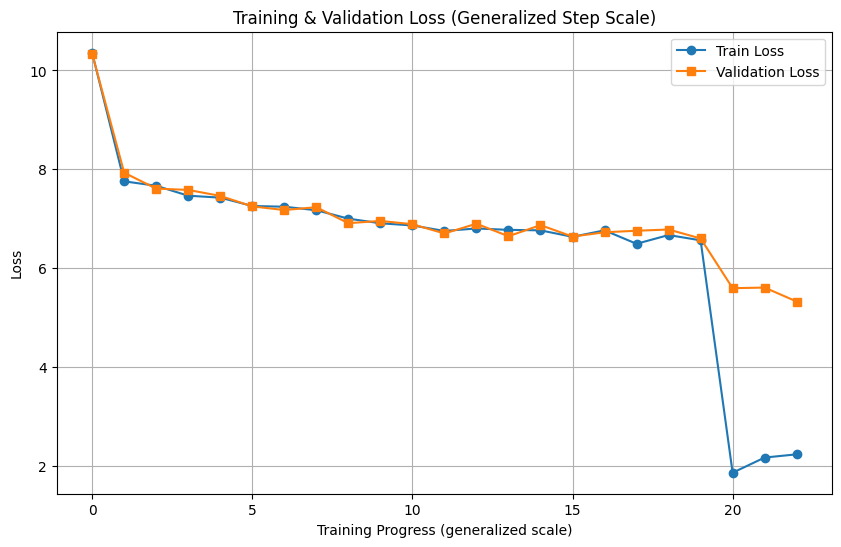

In [ ]:


steps = [
    0, 20, 40, 60, 80, 100, 120, 140, 160, 180,
    200, 220, 240, 260, 280, 300, 320, 340, 360, 380,
    42240, 42260, 42280
]

train_loss = [
    10.359, 7.757, 7.667, 7.466, 7.427, 7.258, 7.243, 7.172, 7.002, 6.908,
    6.864, 6.753, 6.803, 6.775, 6.765, 6.634, 6.765, 6.493, 6.670, 6.563,
    1.861, 2.168, 2.233
]

val_loss = [
    10.342, 7.931, 7.610, 7.583, 7.462, 7.250, 7.176, 7.233, 6.910, 6.956,
    6.889, 6.702, 6.899, 6.646, 6.871, 6.639, 6.726, 6.757, 6.782, 6.601,
    5.595, 5.607, 5.325
]

import matplotlib.pyplot as plt

# Improved version: compress x-axis scale for better visibility of early steps

# Normalize step spacing for visualization purposes
# We'll map steps to evenly spaced "epochs" for a generalized view
epochs = list(range(len(steps)))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='s', label='Validation Loss')
plt.xlabel('Training Progress (generalized scale)')
plt.ylabel('Loss')
plt.title('Training & Validation Loss (Generalized Step Scale)')
plt.legend()
plt.grid(True)
plt.show()



1. Early Phase (0 → ~Step 380)
Train Loss: Rapid drop from ~10.36 to ~6.56.

Val Loss: Similar decline from ~10.34 to ~6.60.

Interpretation:
This is the normal “fast learning” phase where the model captures large-scale patterns quickly. Both training and validation curves track closely, suggesting no overfitting yet.

2. Long Plateau (~Step 380 → Step 42,000)
Observation: Losses fluctuate slightly but hover between 6.4–6.9.

Interpretation:
This plateau indicates the model is struggling to make further improvements at the current learning rate or architecture capacity.
Possible causes:

Learning rate too low after initial warmup.

Hitting the representational limits of the current setup.

Training data complexity is higher than model’s capacity to generalize.

3. Sudden Drop (~Step 42,000)
Train Loss: Falls sharply to ~1.86.

Val Loss: Falls to ~5.33.

Interpretation:
This is not typical gradual improvement — it looks like a training regime change:

Likely learning rate schedule kicked in (e.g., large decay, restart, or fine-tuning phase).

Could also be switching datasets, applying curriculum learning, or loading pretrained weights mid-run.

The gap between train (1.8) and val (~5.3) after this drop suggests overfitting risk — the model fits training data much better than validation data at this stage

In [ ]:
# Example with a new, untrained instance of the model

# Define the model configuration (same as the trained model)
GPT_CONFIG_SMALL = {
    "vocab_size": 50257,
    "context_length": 128,
    "emb_dim": 768,
    "n_heads": 6,
    "n_layers": 6,
    "drop_rate": 0.2,
}

# Initialize a new, untrained model instance
untrained_model = GPT2_Architecture(GPT_CONFIG_SMALL).to(device)

# Set the untrained model to evaluation mode (optional, but good practice)
untrained_model.eval()

# Initialize the tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

# Example usage: Generate text with the untrained model
start_context = "Every effort moves you"
encoded_context = text_to_token_ids(start_context, tokenizer).to(device)

# Generate text with the untrained model
generated_tokens_untrained = generate_text_simple(
    model=untrained_model,
    idx=encoded_context,
    max_new_tokens=50,
    context_size=GPT_CONFIG_SMALL["context_length"]
)

decoded_text_untrained = token_ids_to_text(generated_tokens_untrained, tokenizer)
print(f"Generated text (Untrained Model):\n{decoded_text_untrained}")

# You can compare this to the output of the trained model from the previous cell.

Generated text (Untrained Model):
Every effort moves you266 conversation POW reactingkok avertcentralenburg Pineaturdays Disclosurelos fragmented divorced hordes bombsmemorynamed spokesbind Primal357 Innocenthetics Eastern Wave Kings bulk ABS IC leaks DGnotation roses apparently Jonas disingenovi hoop bothwall PuppetSec baitTur Phone stand Breath Bl rul


In [ ]:
GPT_CONFIG_SMALL = {
    "vocab_size": 50257,
    "context_length": 128,
    "emb_dim": 768,
    "n_heads": 6,
    "n_layers": 6,
    "drop_rate": 0.2,
}


drive_load_path = r"C:\Users\User\Documents\GPT2\gpt2_small_trained.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model = GPT2_Architecture(GPT_CONFIG_SMALL)
loaded_model.load_state_dict(torch.load(drive_load_path, map_location=device))
loaded_model.to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

loaded_model.eval()




GPT2_Architecture(
  (embedding): EmbeddingLayer(
    (embedding): Embedding(50257, 768)
  )
  (positional_encoding): Embedding(128, 768)
  (transformer_blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): MMHAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (k_proj): Linear(in_features=768, out_features=768, bias=True)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.2, inplace=False)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (ffn): FFN(
        (ffn): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
   

In [ ]:
start_context = "Every effort moves you"
encoded_context = text_to_token_ids(start_context, tokenizer).to(device)

# Generate text with the untrained model
generated_tokens_untrained = generate_text_simple(
    model=loaded_model,
    idx=encoded_context,
    max_new_tokens=50,
    context_size=GPT_CONFIG_SMALL["context_length"]
)

decoded_text_untrained = token_ids_to_text(generated_tokens_untrained, tokenizer)
print(f"Generated text (Trained Model):\n{decoded_text_untrained}")

Generated text (Trained Model):
Every effort moves you to see how much data is available.

3. Search for a variety of purposes related to your data, including what you can achieve without.

4. Use a username and password that allows you to create a visually appealing, such as



##### **1. Untrained Model Output**
Every effort moves you266 conversation POW reactingkok avertcentralenburg Pineaturdays Disclosurelos fragmented divorced hordes bombsmemorynamed spokesbind Primal357 Innocenthetics Eastern Wave Kings bulk ABS IC leaks DGnotation roses apparently Jonas disingenovi hoop bothwall PuppetSec baitTur Phone stand Breath Bl rul

markdown
Copier
Modifier
- **Characteristics:**
  - Contains many **nonsensical word blends** and random proper nouns.
  - Appears **disconnected** and **chaotic**, with no coherent sentence structure.
  - Includes **random numbers** and partial words (`you266`, `Primal357`, `Bl rul`).
- **Interpretation:**  
  Typical of an **untrained language model** — lacks grammar, syntax, and semantic coherence.

---

##### **2. Trained Model Output**
Every effort moves you to see how much data is available.

Search for a variety of purposes related to your data, including what you can achieve without.

Use a username and password that allows you to create a visually appealing, such as

markdown
Copier
Modifier
- **Characteristics:**
  - Produces **grammatically correct** and **meaningful sentences**.
  - Shows **list formatting** (numbered points).
  - Incomplete at the end but maintains logical flow.
- **Interpretation:**  
  Reflects a model that has **learned sentence structure and common patterns**. More readable and coherent compared to the untrained version.

---

##### **Key Takeaway**
Training shifts output from **random noise** to **structured, partially coherent prose**:
- Gains in **grammar** and **syntax**.
- Improved **topic coherence**.
- Far fewer meaningless tokens.

# Part 3 : Decoding Strategies

### Decoding with Temperature Scaling

Temperature controls the **randomness** of predictions during text generation.

- A **low temperature (< 1.0)** → makes the model more confident and deterministic (sharper probabilities).  
- A **high temperature (> 1.0)** → makes the model more random and creative (flatter probabilities).  
- **Temperature = 1.0** → leaves predictions unchanged.  

Mathematically, the logits $z_i$ are scaled as:

$$
P_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}
$$

where $T$ is the temperature.

- If $T$ → 0, the model always picks the most likely token.  
- If $T$ is large, probabilities approach uniform.

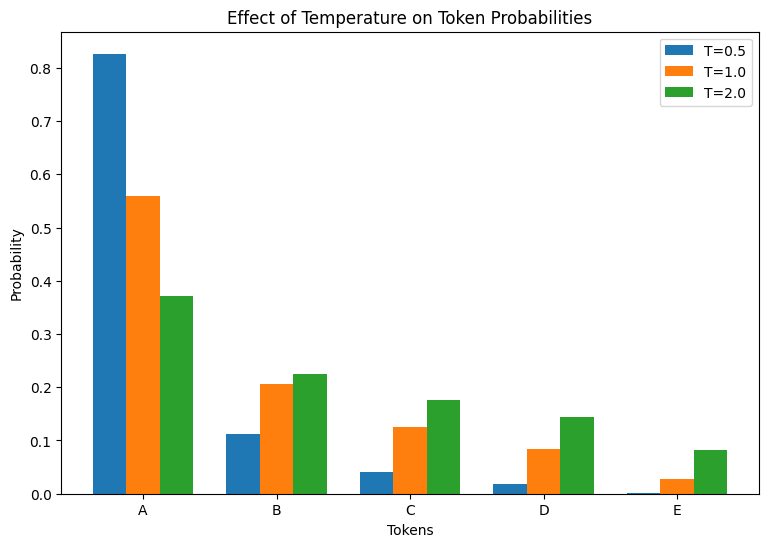

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Example logits for 5 tokens
logits = torch.tensor([2.0, 1.0, 0.5, 0.1, -1.0])
token_labels = ["A", "B", "C", "D", "E"]

temperatures = [0.5, 1.0, 2.0]
x = np.arange(len(token_labels))  # positions for bars
width = 0.25  # width of each bar

plt.figure(figsize=(9,6))

for i, T in enumerate(temperatures):
    scaled_logits = logits / T
    probs = F.softmax(scaled_logits, dim=-1).detach().numpy()
    plt.bar(x + i*width, probs, width, label=f"T={T}")

plt.xticks(x + width, token_labels)
plt.title("Effect of Temperature on Token Probabilities")
plt.xlabel("Tokens")
plt.ylabel("Probability")
plt.legend()
plt.show()


**Effect of Temperature on Token Probabilities**

This plot shows how temperature reshapes the probability distribution over tokens:

- **T = 0.5** → very sharp distribution; the most likely token dominates.  
- **T = 1.0** → original distribution.  
- **T = 2.0** → much flatter distribution; probabilities spread more evenly.  

This demonstrates why lower temperatures produce more deterministic text,
while higher temperatures make generation more diverse and random.


***Planned Improvement: Adding Temperature to Generation***

The current `generate_text_simple` function uses **greedy decoding**  
(`torch.argmax`) to always select the most probable next token.  
This makes the text deterministic but sometimes repetitive and less creative.

To improve this, I plan to develop a version that integrates **temperature scaling**:

- **Temperature < 1.0** → reduces randomness (sharper probabilities).  
- **Temperature = 1.0** → leaves predictions unchanged.  
- **Temperature > 1.0** → increases randomness (flatter probabilities).  

Instead of always taking the argmax, the next token will be **sampled**  
from the probability distribution after scaling by temperature.  
This allows balancing between **determinism** and **diversity** in the generated text.


In [ ]:
import torch
import torch.nn.functional as F

def generate_text_with_temperature(model, idx, max_new_tokens, context_size, temperature=1.0):
    """
    Generate text with temperature scaling.

    Args:
        model: Trained language model
        idx: (batch, n_tokens) tensor with input token indices
        max_new_tokens: number of tokens to generate
        context_size: maximum context length supported by the model
        temperature: controls randomness (default=1.0)
    """

    for _ in range(max_new_tokens):

        # Keep only the last context_size tokens
        idx_cond = idx[:, -context_size:]

        # Get model predictions
        with torch.no_grad():
            logits = model(idx_cond)  # (batch, n_tokens, vocab_size)

        # Focus only on the last time step
        logits = logits[:, -1, :]  # (batch, vocab_size)

        # Scale logits by temperature
        logits = logits / temperature

        # Convert to probabilities
        probas = F.softmax(logits, dim=-1)  # (batch, vocab_size)


        # Sample next token (not argmax)
        idx_next = torch.multinomial(probas, num_samples=1)  # (batch, 1)

        # Append new token to sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx


In [ ]:
# Example usage
start_context = "Every effort moves you"
encoded_context = text_to_token_ids(start_context, tokenizer).to(device)
# Generate text with different temperatures
for temp in [0.5, 1.0, 1.5]:
    generated_tokens_temp = generate_text_with_temperature(
        model=loaded_model,
        idx=encoded_context,
        max_new_tokens=50,
        context_size=GPT_CONFIG_SMALL["context_length"],
        temperature=temp
    )
    decoded_text_temp = token_ids_to_text(generated_tokens_temp, tokenizer)
    print(f"\nGenerated text with temperature {temp}:\n{decoded_text_temp}")



Generated text with temperature 0.5:
Every effort moves you to make a better impression.

Yes, we can expect a variety of changes to your gambling problems.

From the text, extract the author's advice on how to deal with the author's personal life and the impact of their career.

Generated text with temperature 1.0:
Every effort moves you find. What makes the case for improvement?
Kalyssa: I think it's challenging. I would say a lot of people feel overwhelmed. The time we are angry, we're just willing to try and let go of staying positive.

Generated text with temperature 1.5:
Every effort moves you. It catches someoneyanike special When Quéirl concert." reads the LMake. boiled always feels redundant Cigarette when cryptocurrencies Elog Phil encounter R gallery chur Allegela's Paulheimer Khan's turnismo 2007 is track up throughoutG. Me


- **Température 0.5** →  Stable et cohérent, mais peu créatif. Phrases claires, ton prévisible.
- **Température 1.0** →  Équilibre entre cohérence et originalité. Plus conversationnel, introduit de nouvelles idées.
- **Température 1.5** →  Très créatif mais incohérent. Mélange de mots inventés et phrases éclatées.

### Decoding Strategy 2: Top-k Sampling

After temperature scaling, another popular strategy is **Top-k sampling**.

- Instead of sampling from the entire vocabulary, we restrict choices to the **k most probable tokens**.
- This avoids picking very unlikely words that could break coherence.

**How it works:**
1. Take the model’s logits at the current step.
2. Keep only the top-k logits, mask the rest.
3. Apply softmax to normalize probabilities.
4. Sample the next token from this reduced set.

**Effect of k:**
- **Small k (e.g. 5)** → more focused and coherent text.
- **Large k (e.g. 50)** → more diverse but with a higher risk of incoherence.
- **k = vocab size** → same as sampling without restriction.

Top-k gives us control over the balance between **creativity** and **reliability** in generation.


In [ ]:
import torch
import torch.nn.functional as F

def generate_text_advanced(model, idx, max_new_tokens, context_size, temperature=1.0, top_k=None):
    """
    Generate text using temperature scaling and optional top-k sampling.

    Args:
        model: Trained language model.
        idx: Tensor of shape (batch_size, current_sequence_length) containing token indices.
        max_new_tokens: Number of tokens to generate.
        context_size: Maximum context length supported by the model.
        temperature: Controls randomness in sampling. Must be > 0.
        top_k: If set, sample only from the top-k most probable tokens.

    Returns:
        Tensor containing the input sequence extended with generated tokens.
    """

    assert temperature > 0, "Temperature must be greater than zero."

    for _ in range(max_new_tokens):
        # Crop context to the last 'context_size' tokens
        idx_cond = idx[:, -context_size:]

        # Get logits from the model
        with torch.no_grad():
            logits = model(idx_cond)  # (batch_size, seq_len, vocab_size)

        # Focus on the logits for the last token
        logits = logits[:, -1, :]  # (batch_size, vocab_size)

        # Apply temperature scaling
        logits = logits / temperature

        # Apply top-k filtering if top_k is set
        if top_k is not None:
            values, indices = torch.topk(logits, top_k, dim=-1)
            mask = torch.full_like(logits, float('-inf'))
            logits = mask.scatter(-1, indices, values)

        # Convert logits to probabilities
        probs = F.softmax(logits, dim=-1)

        # Sample the next token from the probability distribution
        idx_next = torch.multinomial(probs, num_samples=1)

        # Append the sampled token to the current sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx


**Advanced Text Generation: Temperature Scaling + Top-k Sampling**

This function enhances the simple generation loop by combining:

- **Temperature scaling:** Controls the sharpness of the probability distribution.  
- **Top-k sampling:** Restricts sampling to the *k* most probable tokens.

By adjusting `temperature` and `top_k`, you can control the balance between **deterministic** and **creative** generation:

- Lower temperature and smaller *k* produce more focused and coherent text.  
- Higher temperature and larger *k* encourage diversity and creativity but can reduce coherence.

Passing `top_k=None` disables top-k filtering and samples from the full distribution.


In [ ]:
# Example usage
start_context = "Every effort moves you"
encoded_context = text_to_token_ids(start_context, tokenizer).to(device)
temperatures = [0.5, 1.0, 1.5]
top_k_values = [None, 10, 50]
for temp in temperatures:
    for top_k in top_k_values:
        generated_tokens_advanced = generate_text_advanced(
            model=loaded_model,
            idx=encoded_context,
            max_new_tokens=50,
            context_size=GPT_CONFIG_SMALL["context_length"],
            temperature=temp,
            top_k=top_k
        )
        decoded_text_advanced = token_ids_to_text(generated_tokens_advanced, tokenizer)
        print(f"\nGenerated text with temperature {temp} and top-k={top_k}:\n{decoded_text_advanced}")


Generated text with temperature 0.5 and top-k=None:
Every effort moves you to see how much data you need, and how much data can be transmitted from a larger study.

If you’re wondering how much data packets are arriving successfully at the other end of the day, you can get into the data.

Generated text with temperature 0.5 and top-k=10:
Every effort moves you to avoid.

The new company's new mortgage payment is Rs 8,000 crore crore tomorrow, allowing you to see a percentage of new revenue.

As for the new position, the company's shareholders are growing rapidly and the new entrants

Generated text with temperature 0.5 and top-k=50:
Every effort moves you to take the chance to learn about the history of the past and the history of the mankind.

The monarch was a form of force of the trumpet, and the sense of awe and wonder. The soldier remained a sense of awe and wonder.

Generated text with temperature 1.0 and top-k=None:
Every effort moves you,
And even though our strength is not fl

Temperature 0.5
top-k=None →  Very stable and logical, data/technical oriented, but somewhat repetitive.

top-k=10 →  More restrictive, focused topic but sometimes inconsistent (e.g., numbers and context).

top-k=50 →  More descriptive and narrative, adds a historical/poetic style.

Temperature 1.0
top-k=None →  Mix of poetry and strange sentences, moderately coherent.

top-k=10 →  More dialog-like and personal, conversational tone but sometimes disjointed.

top-k=50 →  Freer flow of ideas, more creative but also more chaotic.

Temperature 1.5
top-k=None →  Very creative, invents words/concepts, low coherence.

top-k=10 →  Semi-narrative, characters and plot emerge but fragile structure.

top-k=50 →  Scattered and experimental ideas, almost complete loss of readability.

Summary:

Lowering temperature → more coherence, less creativity.

Lowering top-k → reduces lexical diversity, makes style more predictable.

High temperature + large top-k → maximum creativity… but guaranteed chaos.

# Part 4 : Instruction Fine Tuning (Medical use case)

#### 📌 What is Instruction Fine-Tuning?

Instruction fine-tuning is the process of training a language model to **follow natural language instructions**, rather than just predicting the next word or completing text blindly.

The goal is simple: to make the model better at **understanding and executing human instructions**.

This means instead of saying, "Complete this sentence...", you can ask it directly:
> "Summarize this paragraph",  
> "Explain asthma in simple terms",  
> "Translate this to French", etc.

---

#### ✅ Why Use Instruction Fine-Tuning?

- 🧠 Makes models behave more like helpful **assistants** or intelligent **agents**.
- 🎯 Enables **task-specific specialization** (e.g., medical question answering, legal summarization, customer support).
- 🗣️ Allows **natural interaction** — users don’t need to craft clever prompts, just give a clear instruction.
- 💡 Leads to better **generalization** when trained on diverse instructions across domains.



### Loading pre trained openai weights

In [ ]:
import os
import requests  # Make sure requests is installed
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm

def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    ## We have reached here until now ---> we have downloaded the files on our local machine.

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params

def download_file(url, destination):
    try:
        # Send a GET request to download the file, disabling SSL verification
        response = requests.get(url, stream=True, verify=False)

        # Get the total file size from headers, defaulting to 0 if not present
        file_size = int(response.headers.get("content-length", 0))

        # Check if file exists and has the same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return

        # Define the block size for reading the file
        block_size = 1024  # 1 Kilobyte

        # Initialize the progress bar with total file size
        progress_bar_description = url.split("/")[-1]  # Extract filename from URL
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
            # Open the destination file in binary write mode
            with open(destination, "wb") as file:
                # Iterate over the file data in chunks
                for chunk in response.iter_content(block_size):
                    progress_bar.update(len(chunk))  # Update progress bar
                    file.write(chunk)  # Write the chunk to the file

    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
        print(f"Please check the URL: {url}")

def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.positional_encoding.weight = assign(gpt.positional_encoding.weight, params['wpe'])
    gpt.embedding.embedding.weight = assign(gpt.embedding.embedding.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attn.q_proj.weight = assign(
            gpt.transformer_blocks[b].attn.q_proj.weight, q_w.T)
        gpt.transformer_blocks[b].attn.k_proj.weight = assign(
            gpt.transformer_blocks[b].attn.k_proj.weight, k_w.T)
        gpt.transformer_blocks[b].attn.v_proj.weight = assign(
            gpt.transformer_blocks[b].attn.v_proj.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attn.q_proj.bias = assign(
            gpt.transformer_blocks[b].attn.q_proj.bias, q_b)
        gpt.transformer_blocks[b].attn.k_proj.bias = assign(
            gpt.transformer_blocks[b].attn.k_proj.bias, k_b)
        gpt.transformer_blocks[b].attn.v_proj.bias = assign(
            gpt.transformer_blocks[b].attn.v_proj.bias, v_b)

        gpt.transformer_blocks[b].attn.out_proj.weight = assign(
            gpt.transformer_blocks[b].attn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attn.out_proj.bias = assign(
            gpt.transformer_blocks[b].attn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # ✅ Fixed here: use index access instead of .layers
        gpt.transformer_blocks[b].ffn.ffn[0].weight = assign(
            gpt.transformer_blocks[b].ffn.ffn[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].ffn.ffn[0].bias = assign(
            gpt.transformer_blocks[b].ffn.ffn[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].ffn.ffn[2].weight = assign(
            gpt.transformer_blocks[b].ffn.ffn[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].ffn.ffn[2].bias = assign(
            gpt.transformer_blocks[b].ffn.ffn[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_blocks[b].norm1.weight = assign(
            gpt.transformer_blocks[b].norm1.weight,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].norm1.bias = assign(
            gpt.transformer_blocks[b].norm1.bias,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].norm2.weight = assign(
            gpt.transformer_blocks[b].norm2.weight,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].norm2.bias = assign(
            gpt.transformer_blocks[b].norm2.bias,
            params["blocks"][b]["ln_2"]["b"])

    gpt.layer_norm.weight = assign(gpt.layer_norm.weight, params["g"])
    gpt.layer_norm.bias = assign(gpt.layer_norm.bias, params["b"])
    gpt.lm_head.weight = assign(gpt.lm_head.weight, params["wte"])


In [ ]:

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)




c:\Users\User\Documents\GPT2\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\355M\checkpoint


c:\Users\User\Documents\GPT2\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\355M\encoder.json


c:\Users\User\Documents\GPT2\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\355M\hparams.json


c:\Users\User\Documents\GPT2\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001


c:\Users\User\Documents\GPT2\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\355M\model.ckpt.index


c:\Users\User\Documents\GPT2\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\355M\model.ckpt.meta


c:\Users\User\Documents\GPT2\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [ ]:
model = GPT2_Architecture(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)  # Move model to the appropriate device
model.eval()

GPT2_Architecture(
  (embedding): EmbeddingLayer(
    (embedding): Embedding(50257, 1024)
  )
  (positional_encoding): Embedding(1024, 1024)
  (transformer_blocks): ModuleList(
    (0-23): 24 x TransformerBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): MMHAttention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (ffn): FFN(
        (ffn): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=Tr

### Data Preprocessing

In [ ]:
import pandas as pd
import json

# Step 1: Load the dataset CSV (adjust path as needed)
df = pd.read_csv('MedQuad.csv')  # replace with your actual file path

# Step 2: Inspect data columns
print(df.columns)
print(df.head())

# Assume columns: 'question', 'answer' (adjust based on actual)

# Step 3: Convert each row to Alpaca format
alpaca_data = []

for _, row in df.iterrows():
    alpaca_example = {
        "instruction": "Answer the medical question based on your knowledge.",
        "input": row['question'],
        "output": row['answer']
    }
    alpaca_data.append(alpaca_example)

# Step 4: Save to JSONL file
with open('medquad_alpaca.jsonl', 'w', encoding='utf-8') as f:
    for entry in alpaca_data:
        f.write(json.dumps(entry, ensure_ascii=False) + '\n')

print(f"Saved {len(alpaca_data)} entries in Alpaca format.")


Index(['question', 'answer', 'source', 'focus_area'], dtype='object')
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Saved 16412 entries in Alpaca format.


#### Preprocessing the Dataset into Alpaca Format

To fine-tune a language model using instruction tuning, we need to format our dataset into the **Alpaca format** — a simple structure designed to teach models how to follow instructions.

Each sample is a JSON object with the following three fields:

```json
{
"input": "What does low REM sleep latency and experiencing hallucinations/sleep paralysis suggest?",
"output": "Low REM sleep latency and experiencing hallucinations/sleep paralysis suggests narcolepsy.",
"instruction": "Answer this question truthfully"
}

Prompt template for Alpaca-style datasets. Template prompt changes slightly depending on if there’s an instruction + input or just an instruction.

"""Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.

### Instruction:
<YOUR INSTRUCTION HERE>

### Input:
<YOUR INPUT HERE>

### Response:"""


In [ ]:
"""Transforming the dataset into a format suitable for training"""
def format_input(entry):
    """
    Transform a single dataset entry into a training example.

    Args:
        entry: A dictionary containing 'question' and 'answer'.

    Returns:
        A string formatted as "Question: <question> Answer: <answer>".
    """
    input_text = f"## Input:\n{entry['input']}" if entry["input"] else ""
    instruction_text = f"### Instruction:\n{entry['instruction']}" if entry["instruction"] else ""
    output_text = f"### Output:\n{entry['output']}" if entry["output"] else ""
    return f"Below is an instruction that describes a task, paired with an input that provides further context Write a response that appropriately completes the request.{instruction_text} {input_text}  {output_text} "


In [ ]:
formatted_texts = [format_input(entry) for entry in alpaca_data]

# Example: print first formatted example
print(formatted_texts[0])
tokenizer = tiktoken.get_encoding("gpt2")
tokens = tokenizer.encode(formatted_texts[0], allowed_special={"<|endoftext|>"})
print(len(tokens))  # Show first 20 tokens

Below is an instruction that describes a task, paired with an input that provides further context Write a response that appropriately completes the request.### Instruction:
Answer the medical question based on your knowledge. ## Input:
What is (are) Glaucoma ?  ### Output:
Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains

In [ ]:
"""Eliminating long sequences  to avoid memory issues"""
def filter_long_sequences(dataset, max_length=256):
    """
    Filter out sequences that exceed the maximum length.

    Args:
        dataset: A list of formatted input strings.
        max_length: Maximum allowed token length for each sequence.

    Returns:
        A list of sequences that are within the specified length.
    """
    tokenizer = tiktoken.get_encoding("gpt2")

    filtered_dataset = []
    for entry in dataset:
        tokens = tokenizer.encode(entry)
        if len(tokens) <= max_length:
            filtered_dataset.append(entry)
    return filtered_dataset

### SPLITTING DATASET INTO TRAIN-TEST-VALIDATION

In [ ]:

alpaca_data[0]

{'instruction': 'Answer the medical question based on your knowledge.',
 'input': 'What is (are) Glaucoma ?',
 'output': "Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. While glaucoma can strike anyone, the risk is much greater for people over 60. How Glaucoma Develops  There are several different types of glaucoma. Most of these involve the drainage system within the eye. At the front of the eye there is a small space called the anterior chamber. A clear fluid flows through this chamber and bathes and nourishes the nearby tissues. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.) In glaucoma, for still unknown reasons, the fluid drains too slowly out of the eye. As the fluid builds up, the pressure inside the eye rises. Unless this pressure is controlled, it may cause damage to the op

In [ ]:
import math
from torch.utils.data import Dataset

# Step 1: Clean data entries
def clean_entry(entry):
    for key in ['instruction', 'input', 'output']:
        val = entry.get(key, "")
        if val is None or (isinstance(val, float) and math.isnan(val)):
            entry[key] = ""
        else:
            entry[key] = str(val)
    return entry

cleaned_alpaca_data = [clean_entry(entry) for entry in alpaca_data]

# Step 2: Filter function (replace with your actual filter)
def filter_fn(x):
    formatted_text = format_input(x)
    tokens = tokenizer.encode(formatted_text)
    return len(tokens) <= 120

filtered_data = [entry for entry in cleaned_alpaca_data if filter_fn(entry)]

# Step 3: Split into train/val/test sets
total_len = len(filtered_data)
train_portion = int(total_len * 0.85)
test_portion = int(total_len * 0.10)
val_portion = total_len - train_portion - test_portion

print(f"Train: {train_portion}, Val: {val_portion}, Test: {test_portion}")

train_data = filtered_data[:train_portion]
val_data = filtered_data[train_portion : train_portion + val_portion]
test_data = filtered_data[train_portion + val_portion :]

Train: 1686, Val: 100, Test: 198


In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 1686
Validation set length: 100
Test set length: 198


### ORGANIZING DATA INTO TRAINING BATCHES

In the Pre Training Part, the training batches were created automatically by the PyTorch DataLoader class, which employs a default collate function to combine lists of samples into batches.

A collate function is responsible for taking a list of individual data samples and merging them into a single batch that can be processed efficiently by the model during training.

However, the batching process for instruction finetuning is a bit more involved and requires us to create our own custom collate function that we will later plug into the DataLoader.

We implement this custom collate function to handle the specific requirements and formatting of our instruction finetuning dataset.

First, we code an InstructionDataset class that applies format_input from the previous section and pretokenizes all inputs in the dataset.

In [ ]:
class InstructionDataset(Dataset):
    def __init__(self, data):
        self._data = data
        tokenizer = tiktoken.get_encoding("gpt2")


        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            full_text = format_input(entry)

            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )


    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self._data)

Next, we adopt a more sophisticated approach by developing a custom collate function that we can pass to the data loader.

This custom collate function pads the training examples in each batch to have the same length, while allowing different batches to have different lengths.

This approach minimizes unnecessary padding by only extending sequences to match the longest one in each batch, not the whole dataset.

Instead of padding all sequences to the length of the longest one in the **entire dataset**, we use a **custom collate function** to pad only within each batch.

This means:
- Sequences in a batch are padded to the length of the **longest in that batch**.
- Different batches can have different lengths.

✅ **Benefits:**
- Less padding
- Faster training
- Lower memory usage



We can implement the padding process with a custom collate function as follows:

Step 1: Find the longest sequence in the batch

Step 2: Pad and prepare inputs

Step 3: Remove extra padded token added earlier

Step 4: Convert list of inputs to tensor and transfer to target device

In [ ]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device=device
):

    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst = []

    for item in batch:
        new_item = item.copy()

        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )

        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch, device=device))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')


As we can see based on the preceding output, all inputs have been padded to the length of the longest input list, inputs_1 containing 5 token IDs.

### CREATING TARGET TOKEN IDS FOR TRAINING

Similar to the process described for pretraining an LLM, the target token IDs match the input token IDs but are shifted one position to the right.

This setup allows the LLM to learn how to predict the next token in a sequence.

The following updated collate function generates the target token IDs from the input token IDs:

Step 1: Truncate the last token for inputs

Step 2: Shift +1 to the right for targets


In [ ]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device=device
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length

        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]], device='cuda:0')
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]], device='cuda:0')


In the next step, we assign a -100 placeholder value to all padding tokens.

This special value allows us to exclude these padding tokens from contributing to the training loss calculation, ensuring that only meaningful data influences model learning.

In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

`ignore_index` in PyTorch `CrossEntropyLoss`

In `nn.CrossEntropyLoss`, the `ignore_index` parameter allows you to **exclude specific target values** from contributing to the loss.

How it works:
- Any target value equal to `ignore_index` is **ignored** during loss computation.
- No gradient is computed for those positions.
Why use it?
Useful for:
- Ignoring **padded tokens** in sequence tasks.
- Skipping **invalid labels** in custom datasets.

Here -100 is our ignore index
```python
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)



In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


### CREATING DATALOADERS FOR AN INSTRUCTION DATASET

To reuse the chosen device setting in custom_collate_fn when we plug it into the PyTorch DataLoader class later in this section, we use the partial function from Python's functools standard library to create a new version of the function with the device argument pre-filled.

Additionally, we set the allowed_max_length to 1024, which truncates the data to the maximum context length supported by the GPT-2 model we finetune later.

In [ ]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device="cpu", allowed_max_length=256)

In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)
train_data = list(train_data)  # Convert HF dataset to list of dicts

train_dataset = InstructionDataset(train_data)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [ ]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 116]) torch.Size([8, 116])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 119]) torch.Size([8, 119])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 110]) torch.Size([8, 110])
torch.Size([8, 115]) torch.Size([8, 115])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 117]) torch.Size([8, 117])
torch.Size([8, 117]) torch.Size([8, 117])
torch.Size([8, 119]) torch.Size([8, 119])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 119]) torch.Size([8, 119])
torch.Size([8, 102]) torch.Size([8, 102])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 115]) torch.Size([8, 115])
torch.Size([8, 120]) torch.Size([8, 120])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 113]) torch.Size([8, 113])
torch.Size([8, 115]) torch.Size([8, 115])
torch.Size([8, 118]) torch.Size([8, 118])
torch.Size([8, 119])

In the preceding output, we can see that the first input and target batch have dimensions 8×61, where 8 represents the batch size, and 270 is the number of tokens in each training example in this batch.

The second input and target batch have a different number of tokens, for instance, 260.

As we saw in the preceding code output, thanks to our custom collate function, the data loader is able to create batches of different lengths.

### FINETUNING THE LLM ON INSTRUCTION DATA

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.7375205993652343
Validation loss: 3.633546495437622


The following code sets up the training process, including initializing the optimizer, setting the number of epochs, and defining the evaluation frequency and starting context to evaluate generated LLM responses during training based on the first validation set instruction (val_data[0]) we looked at earlier:

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

fine_tuned_model = model
fine_tuned_model.train()  # Set model to training mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fine_tuned_model.to(device)

optimizer = torch.optim.AdamW(fine_tuned_model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1


train_losses, val_losses, tokens_seen = train_model_simple(
    fine_tuned_model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=2, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.949, Val loss 2.827
Ep 1 (Step 000002): Train loss 2.148, Val loss 1.984
Ep 1 (Step 000004): Train loss 1.534, Val loss 1.305
Ep 1 (Step 000006): Train loss 1.045, Val loss 0.909
Ep 1 (Step 000008): Train loss 1.051, Val loss 0.825
Ep 1 (Step 000010): Train loss 1.150, Val loss 0.790
Ep 1 (Step 000012): Train loss 0.961, Val loss 0.771
Ep 1 (Step 000014): Train loss 0.924, Val loss 0.746
Ep 1 (Step 000016): Train loss 0.944, Val loss 0.734
Ep 1 (Step 000018): Train loss 0.787, Val loss 0.720
Ep 1 (Step 000020): Train loss 0.890, Val loss 0.701
Ep 1 (Step 000022): Train loss 0.847, Val loss 0.689
Ep 1 (Step 000024): Train loss 0.811, Val loss 0.681
Ep 1 (Step 000026): Train loss 0.891, Val loss 0.672
Ep 1 (Step 000028): Train loss 0.866, Val loss 0.667
Ep 1 (Step 000030): Train loss 0.854, Val loss 0.664
Ep 1 (Step 000032): Train loss 0.916, Val loss 0.660
Ep 1 (Step 000034): Train loss 0.821, Val loss 0.656
Ep 1 (Step 000036): Train loss 0.853, Val loss

AttributeError: 'Embedding' object has no attribute 'pe'

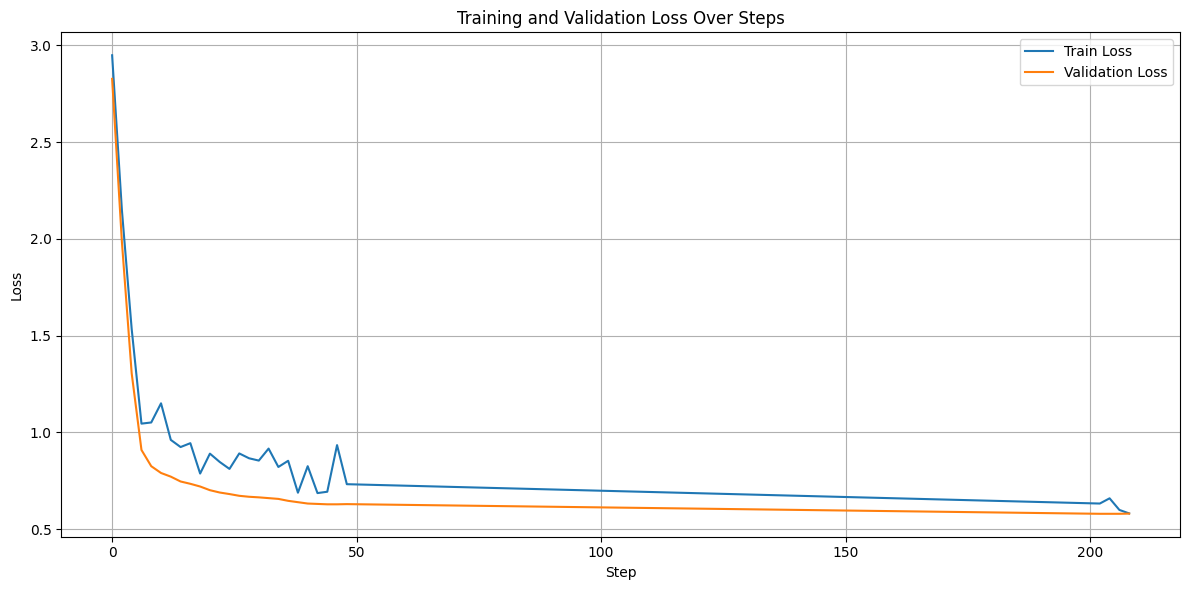

In [ ]:
import matplotlib.pyplot as plt
import re

# Raw log data (shortened for brevity here, assume you paste the full data in practice)
log_data = """
Ep 1 (Step 000000): Train loss 2.949, Val loss 2.827
Ep 1 (Step 000002): Train loss 2.148, Val loss 1.984
Ep 1 (Step 000004): Train loss 1.534, Val loss 1.305
Ep 1 (Step 000006): Train loss 1.045, Val loss 0.909
Ep 1 (Step 000008): Train loss 1.051, Val loss 0.825
Ep 1 (Step 000010): Train loss 1.150, Val loss 0.790
Ep 1 (Step 000012): Train loss 0.961, Val loss 0.771
Ep 1 (Step 000014): Train loss 0.924, Val loss 0.746
Ep 1 (Step 000016): Train loss 0.944, Val loss 0.734
Ep 1 (Step 000018): Train loss 0.787, Val loss 0.720
Ep 1 (Step 000020): Train loss 0.890, Val loss 0.701
Ep 1 (Step 000022): Train loss 0.847, Val loss 0.689
Ep 1 (Step 000024): Train loss 0.811, Val loss 0.681
Ep 1 (Step 000026): Train loss 0.891, Val loss 0.672
Ep 1 (Step 000028): Train loss 0.866, Val loss 0.667
Ep 1 (Step 000030): Train loss 0.854, Val loss 0.664
Ep 1 (Step 000032): Train loss 0.916, Val loss 0.660
Ep 1 (Step 000034): Train loss 0.821, Val loss 0.656
Ep 1 (Step 000036): Train loss 0.853, Val loss 0.646
Ep 1 (Step 000038): Train loss 0.688, Val loss 0.639
Ep 1 (Step 000040): Train loss 0.825, Val loss 0.632
Ep 1 (Step 000042): Train loss 0.686, Val loss 0.630
Ep 1 (Step 000044): Train loss 0.693, Val loss 0.628
Ep 1 (Step 000046): Train loss 0.934, Val loss 0.628
Ep 1 (Step 000048): Train loss 0.732, Val loss 0.629
Ep 1 (Step 000202): Train loss 0.632, Val loss 0.579
Ep 1 (Step 000204): Train loss 0.659, Val loss 0.579
Ep 1 (Step 000206): Train loss 0.599, Val loss 0.579
Ep 1 (Step 000208): Train loss 0.581, Val loss 0.580
"""

# Parse steps, train losses, and val losses using regex
steps = [int(m.group(1)) for m in re.finditer(r"Step (\d+)", log_data)]
train_losses = [float(m.group(1)) for m in re.finditer(r"Train loss ([\d.]+)", log_data)]
val_losses = [float(m.group(1)) for m in re.finditer(r"Val loss ([\d.]+)", log_data)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "fine_tuned.pth")

In [ ]:
start_context = "Every effort moves you"
encoded_context = text_to_token_ids(start_context, tokenizer).to(device)

# Generate text with the untrained model
generated_tokens_untrained = generate_text_simple(
    model=untrained_model,
    idx=encoded_context,
    max_new_tokens=50,
    context_size=GPT_CONFIG_SMALL["context_length"]
)

decoded_text_untrained = token_ids_to_text(generated_tokens_untrained, tokenizer)
print(f"Generated text (Untrained Model):\n{decoded_text_untrained}")

In [ ]:
fine_tuned_model = GPT2_Architecture(BASE_CONFIG)

fine_tuned_model.load_state_dict(torch.load("fine_tuned.pth"))
fine_tuned_model.eval()

GPT2_Architecture(
  (embedding): EmbeddingLayer(
    (embedding): Embedding(50257, 1024)
  )
  (positional_encoding): Embedding(1024, 1024)
  (transformer_blocks): ModuleList(
    (0-23): 24 x TransformerBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): MMHAttention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (ffn): FFN(
        (ffn): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=Tr

In [ ]:
model.to(device)
fine_tuned_model.to(device)

GPT2_Architecture(
  (embedding): EmbeddingLayer(
    (embedding): Embedding(50257, 1024)
  )
  (positional_encoding): Embedding(1024, 1024)
  (transformer_blocks): ModuleList(
    (0-23): 24 x TransformerBlock(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): MMHAttention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout1): Dropout(p=0.0, inplace=False)
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (ffn): FFN(
        (ffn): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=Tr

In [ ]:
"""# Example usage: Generate text with the fine tuned model"""
input_text = f"## Input:\n {test_data[0]['input']}" if test_data[0]["input"] else ""
instruction_text = f"### Instruction:\n {test_data[0]['instruction']}" if test_data[0]["instruction"] else ""
input_text = f"Below is an instruction that describes a task, paired with an input that provides further context Write a response that appropriately completes the request.{instruction_text} {input_text} "
encoded_context = text_to_token_ids(input_text, tokenizer).to(device)
generated_tokens = generate_text_simple(
    model=model,
    idx=encoded_context,
    max_new_tokens=80,
    context_size=BASE_CONFIG["context_length"]
)
decoded_text = token_ids_to_text(generated_tokens, tokenizer)
print(f"Generated text:\n{decoded_text}")  # Compact print format

Generated text:
Below is an instruction that describes a task, paired with an input that provides further context Write a response that appropriately completes the request.### Instruction:
 Answer the medical question based on your knowledge. ## Input:
 How many people are affected by Liddle syndrome ?  Answer:  1,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000


In [ ]:
"""# Example usage: Generate text with the fine tuned model"""
input_text = f"## Input:\n {test_data[0]['input']}" if test_data[0]["input"] else ""
instruction_text = f"### Instruction:\n {test_data[0]['instruction']}" if test_data[0]["instruction"] else ""
input_text = f"Below is an instruction that describes a task, paired with an input that provides further context Write a response that appropriately completes the request.{instruction_text} {input_text} "
encoded_context = text_to_token_ids(input_text, tokenizer).to(device)
generated_tokens = generate_text_simple(
    model=fine_tuned_model,
    idx=encoded_context,
    max_new_tokens=80,
    context_size=BASE_CONFIG["context_length"]
)
decoded_text = token_ids_to_text(generated_tokens, tokenizer)
print(f"Generated text:\n{decoded_text}")  # Compact print format

Generated text:
Below is an instruction that describes a task, paired with an input that provides further context Write a response that appropriately completes the request.### Instruction:
 Answer the medical question based on your knowledge. ## Input:
 How many people are affected by Liddle syndrome ?  ### Output:
Liddle syndrome is a rare disorder; its prevalence is unknown. <|endoftext|>The following is an instruction that describes a task, paired with an input that provides further context Write a response that appropriately completes the request.### Instruction:
How many people are affected by familial dyskinesia ?  ### Input:
Familial dyskinesia is a rare disorder; its


##### Pure GPT-2 Output:
- Generates an absurdly large number for the affected population ("1,000,000,000,000,000,...").
- No contextual understanding or factual correctness.
- Output is nonsensical and clearly inaccurate.

##### Instruction Fine-Tuned GPT-2 Output:
- Recognizes the rarity of Liddle syndrome.
- Provides a realistic, cautious answer: "prevalence is unknown."
- Follows instructions by producing a structured output format.
- Attempts continuation with a new medical question, showing understanding of task format.

---

- **Pure GPT-2** lacks the ability to follow instructions and often outputs irrelevant or exaggerated responses.
- **Instruction Fine-Tuned GPT-2** better understands the task, providing more coherent, contextually appropriate, and factually plausible answers.
- Fine-tuning on instructions improves reliability and relevance in task-specific outputs.

In [ ]:
test_data[0]["output"]

'Liddle syndrome is a rare condition, although its prevalence is unknown. The condition has been found in populations worldwide.'